In [17]:
!pip install transformers torch pandas scikit-learn mlflow matplotlib seaborn wordcloud tensorflow tensorflow-data-validation zenml tweepy cassandra-driver


In [18]:
# General imports
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
import warnings
# Suppress deprecated warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module=".*tensorflow.*")
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import numpy as np
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import numpy as np
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import BertTokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_data_validation as tfdv
import mlflow
import mlflow.tensorflow
# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# ZenML imports
from zenml.steps import step
from zenml.pipelines import pipeline
# For Twitter API (if needed for real-time data)
import tweepy
# Other imports you might need (depending on your exact requirements)
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'
import json
import requests
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import uuid
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import pandas as pd
import logging

In [19]:
# Constants and Hyperparameters
CSV_FILE_PATH = 'C:\\Users\\LENOVO\\Desktop\\CSC5356_SP24\\scripts\\dataset.csv'
PRETRAINED_LM_PATH = 'C:\\Users\\LENOVO\\Desktop\\bert-election2020-twitter-stance-biden'
HYPERPARAMS = {
    "batch_size": 16,
    "learning_rate": 2e-5,
    "epochs": 2,
    "weight_decay": 0.01,
    'max_grad_norm': 1.0,
    'lr_step_size': 1,
    'lr_gamma': 0.1,
    
}
print("Hyperparameters:", HYPERPARAMS)

Hyperparameters: {'batch_size': 16, 'learning_rate': 2e-05, 'epochs': 2, 'weight_decay': 0.01, 'max_grad_norm': 1.0, 'lr_step_size': 1, 'lr_gamma': 0.1}


In [20]:
data = pd.read_csv(CSV_FILE_PATH)

In [21]:
data.set_index('tweet_id', inplace = True)

In [22]:
data.head()

,text,label
tweet_id,,
1298098337946783745,"@USER @USER and like you, they are all squish ...",NONE
1296643755022397440,.@USER on covid-19: we'll put the politics asi...,FAVOR
1293907151501459462,"@USER google: how to vote early in ""your state...",FAVOR
1239356229803225088,am i the only one that pictures biden this way...,NONE
1298801129984266241,@USER was it the infanticide lie the nun dropp...,NONE


In [23]:
if data.isnull().values.any():
            null_counts = data.isnull().sum()
            print("Warning: Null values found in the dataset.")
            print(f"Null value counts by column:\n{null_counts[null_counts > 0]}")

In [24]:
expected_columns = {'text','label'}

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375 entries, 1298098337946783745 to 1292574112263610369
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    375 non-null    object
 1   label   375 non-null    object
dtypes: object(2)
memory usage: 8.8+ KB


In [26]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [27]:
data.text.iloc[10]

'listened to both these guys for 2 hours tonight. much of what i heard is more big government that promises free/free/free, open borders, killing the oil industry and more. thanks, but we went through 8 years of that with obama and many of us do not want to go back.... #demdebate'

In [28]:
data.label.value_counts()

NONE       157
FAVOR      112
AGAINST    106
Name: label, dtype: int64

<ipython-input-29-072bda58b367>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data.label, palette='Spectral')


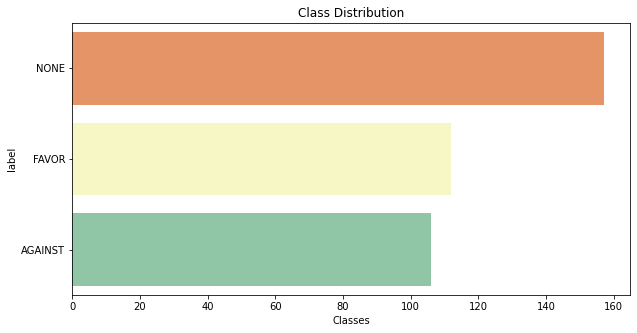

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(data.label, palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution');

In [30]:
def clean_text(text):
        """
        Function to clean text data.

        Args:
            text (str): Text to be cleaned.

        Returns:
            str: Cleaned text.
        """
        # Removing URLs
        text = re.sub(r'http\S+', '', text)
        # Removing usernames and hashtags
        text = re.sub(r'@\S+|#\S+', '', text)
        # Removing special characters and numbers
        text = re.sub(r'[^A-Za-z\s]', '', text)
        # Converting to lowercase
        text = text.lower().strip()
        # Tokenize and rejoin the text to ensure clean tokenization
        tokens = text.split()
        return ' '.join(tokens)

In [31]:
expected_columns = {'text','label'}
if not expected_columns.issubset(data.columns):
    missing_cols = expected_columns - set(data.columns)
    error_msg = f"The dataframe is missing the following required columns: {', '.join(missing_cols)}"
    logging.error(error_msg)
    raise ValueError(error_msg)

In [32]:
print("Preprocessing the data...")
missing_label_rows = data[data['label'].isna()]


Preprocessing the data...


In [33]:
data.dropna(subset=['label'], inplace=True)

In [34]:
if not missing_label_rows.empty:
    print(f"Rows with missing labels:\n{missing_label_rows}")
# If the DataFrame is empty after dropping missing values, return it as is
if data.empty:
    print("The DataFrame is empty after preprocessing.")

In [35]:
# Encode labels
label_mapping = {'NONE': 0, 'FAVOR': 1, 'AGAINST': 2}
data['label'] = data['label'].map(label_mapping)

In [36]:
data.head(15)

,text,label
tweet_id,,
1298098337946783745,"@USER @USER and like you, they are all squish ...",0
1296643755022397440,.@USER on covid-19: we'll put the politics asi...,1
1293907151501459462,"@USER google: how to vote early in ""your state...",1
1239356229803225088,am i the only one that pictures biden this way...,0
1298801129984266241,@USER was it the infanticide lie the nun dropp...,0
1310982880865275907,@USER i think all the ‘lids’ on the biden camp...,2
1302050245820506112,you know how they say anyone can be president?...,1
1239344169518116864,biden is mostly campaigning for the general el...,0
1295022959787151360,so jazzed to get to meet future u.s.rep @USER ...,0


In [37]:
# Validate the encoding
unique_labels = data['label'].unique()
if set(unique_labels) != {0, 1, 2}:
    error_msg = f"Labels are not correctly mapped. Found unique labels: {unique_labels}"
    logging.error(error_msg)
    raise ValueError(error_msg)

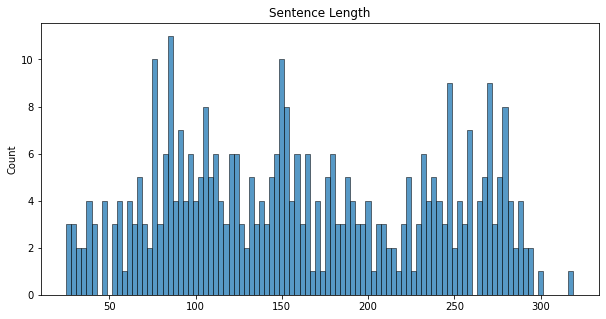

In [38]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in data.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [39]:
# Visualize Missing Values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
missing_df = pd.DataFrame({'Feature': missing_values.index, 'MissingValues': missing_values, 'Percentage': missing_percentage})
# Filter out features with no missing values
missing_df = missing_df[missing_df['MissingValues'] > 0].sort_values('Percentage', ascending=False)
# Plotting missing values (if there are any)
if not missing_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Percentage', y='Feature', data=missing_df)
    plt.title('Percentage of Missing Values per Feature')
    plt.xlabel('Percentage')
    plt.ylabel('Feature')
    plt.show()
else:
    print("No missing values found in the dataset.")


No missing values found in the dataset.


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


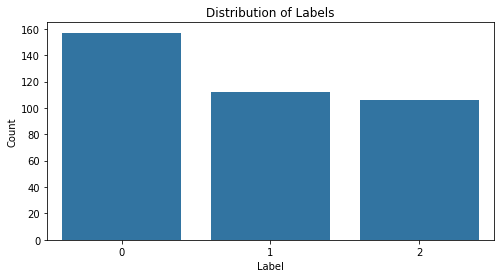

In [40]:
# Data Distribution Visualization
if 'label' in data.columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x='label', data=data)
    plt.title('Distribution of Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()
else:
    print("Label column not found, skipping label distribution visualization.")

In [41]:
# Define the size for your test and validation sets
test_size = 0.2
validation_size = 0.1

# Initial split to separate out the test set
train_val_data, test_data = train_test_split(data, test_size=test_size, random_state=42)

# Calculate the adjusted validation size based on the remaining data after test split
adjusted_validation_size = validation_size / (1 - test_size)

# Split the remaining data into training and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=adjusted_validation_size, random_state=42)

In [42]:
train_stats = tfdv.generate_statistics_from_dataframe(train_data)

In [43]:
tfdv.visualize_statistics(train_stats)

In [44]:
val_stats = tfdv.generate_statistics_from_dataframe(val_data)

In [45]:
tfdv.visualize_statistics(val_stats)

In [46]:
test_stats = tfdv.generate_statistics_from_dataframe(test_data)

In [47]:
tfdv.visualize_statistics(test_stats)

In [48]:
# Infer schema from training data
schema = tfdv.infer_schema(statistics=train_stats)
print("Schema inferred from the testing data.")

Schema inferred from the testing data.


In [49]:
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'text',BYTES,required,,-
'label',INT,required,,-
'tweet_id',INT,required,,-


In [50]:
for dataset_name, dataset_stats in [('Validation', val_stats), ('Test', test_stats)]:
    print(f"Validating {dataset_name} data...")
    anomalies = tfdv.validate_statistics(statistics=dataset_stats, schema=schema)
    if anomalies.anomaly_info:
        print(f"Anomalies found in {dataset_name} data:")
        tfdv.display_anomalies(anomalies)
    else:
        print(f"No anomalies detected in {dataset_name} data.")

Validating Validation data...
No anomalies detected in Validation data.
Validating Test data...
No anomalies detected in Test data.


In [51]:
anomalies = tfdv.validate_statistics(statistics=train_stats, schema=schema)
tfdv.display_anomalies(anomalies)


In [52]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM_PATH)
from cassandra.policies import DCAwareRoundRobinPolicy

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [53]:
print("Connecting to the Cassandra Database...")
cluster = Cluster(contact_points=['127.0.0.1'],port=9042,load_balancing_policy=DCAwareRoundRobinPolicy())
session = cluster.connect()
session.set_keyspace('keyspace')

Connecting to the Cassandra Database...


<ipython-input-53-8e8417ee951a>:2: DeprecationWarning: Legacy execution parameters will be removed in 4.0. Consider using execution profiles.
  cluster = Cluster(contact_points=['127.0.0.1'],port=9042,load_balancing_policy=DCAwareRoundRobinPolicy())


Downgrading core protocol version from 66 to 65 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
Downgrading core protocol version from 65 to 5 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
Using datacenter 'datacenter1' for DCAwareRoundRobinPolicy (via host '127.0.0.1:9042'); if incorrect, please specify a local_dc to the constructor, or limit contact points to local cluster nodes


In [54]:
import warnings
warnings.filterwarnings('ignore')
from transformers import BertTokenizer
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra import ConsistencyLevel
import uuid
import pandas as pd
import logging

In [55]:

insert_statement = session.prepare('INSERT INTO "keyspace".features (id, features) VALUES (?, ?)')
batch = BatchStatement(consistency_level=ConsistencyLevel.ONE)
batch_size_limit = 16
if 'tokens' not in data.columns:
    data['tokens'] = None

for index, row in data.iterrows():
    row_id = uuid.uuid4()
    tokens = tokenizer.encode(row['text'], add_special_tokens=True)
    data.at[index, 'tokens'] = tokens
    batch.add(insert_statement, (row_id, tokens))

    if len(batch) >= batch_size_limit:
        session.execute(batch)
        batch.clear()

if len(batch) > 0:
    session.execute(batch)

    print("Feature engineering and data insertion completed successfully.")

Server warning: Batch for ["keyspace".features] is of size 26768, exceeding specified threshold of 5120 by 21648.
Server warning: Batch for ["keyspace".features] is of size 24068, exceeding specified threshold of 5120 by 18948.
Server warning: Batch for ["keyspace".features] is of size 25868, exceeding specified threshold of 5120 by 20748.
Server warning: Batch for ["keyspace".features] is of size 28172, exceeding specified threshold of 5120 by 23052.
Server warning: Batch for ["keyspace".features] is of size 28892, exceeding specified threshold of 5120 by 23772.
Server warning: Batch for ["keyspace".features] is of size 26588, exceeding specified threshold of 5120 by 21468.
Server warning: Batch for ["keyspace".features] is of size 21512, exceeding specified threshold of 5120 by 16392.
Server warning: Batch for ["keyspace".features] is of size 25472, exceeding specified threshold of 5120 by 20352.
Server warning: Batch for ["keyspace".features] is of size 27020, exceeding specified th

In [56]:
# Fetch all table names in the keyspace
rows = session.execute("SELECT table_name FROM system_schema.tables WHERE keyspace_name = %s", ["keyspace"])
table_names = [row[0] for row in rows]

for table_name in table_names:
    print(f"Contents of table {table_name}:")
    rows = session.execute(f"SELECT * FROM {table_name}")
    for row in rows:
        print(row)
    print("\n")

Contents of table features:
Row(id=UUID('35b0fcda-3735-4e6c-90b3-a68d4531cfed'), features=[101, 1030, 5310, 1030, 5310, 1030, 5310, 10699, 6689, 2030, 2041, 1998, 2041, 4688, 1010, 2030, 2119, 999, 1001, 8398, 11387, 11387, 102])
Row(id=UUID('f5ee64f7-1ab8-4fd9-877f-25ab6b337dfc'), features=[101, 8398, 2003, 1037, 8040, 3286, 5017, 1012, 1012, 1012, 2119, 2010, 5952, 1998, 2010, 2118, 2002, 2003, 1037, 8040, 3286, 5017, 2017, 2145, 2079, 2025, 2644, 4637, 2068, 8398, 2003, 1037, 8040, 3286, 5017, 1010, 2119, 2010, 5952, 1998, 2010, 2118, 2024, 8040, 3286, 16862, 2017, 2145, 2079, 2025, 2507, 2039, 2115, 2490, 1001, 8398, 11387, 11387, 1001, 7226, 2368, 1001, 6734, 21572, 22199, 2015, 1001, 2304, 3669, 6961, 18900, 3334, 8299, 102])
Row(id=UUID('6cf01373-e0fa-445c-ad96-6a71cec94af1'), features=[101, 2023, 7427, 1997, 4464, 4790, 2006, 21887, 1010, 4331, 1010, 5446, 2739, 2064, 2022, 2179, 2012, 8299, 1037, 2655, 2000, 7308, 2039, 1024, 7226, 2368, 23876, 2163, 2000, 11405, 1010, 4841, 2

In [57]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [58]:
data['data_type'] = ['not_set'] * data.shape[0]
data.head()

,text,label,tokens,data_type
tweet_id,,,,
1298098337946783745,"@USER @USER and like you, they are all squish #gop weasels who will be in tears on election night.",0,"[101, 1030, 5310, 1030, 5310, 1998, 2066, 2017, 1010, 2027, 2024, 2035, 5490, 27020, 2232, 1001, 2175, 2361, 29268, 2015, 2040, 2097, 2022, 1999, 4000, 2006, 2602, 2305, 1012, 102]",not_set
1296643755022397440,.@USER on covid-19: we'll put the politics aside. we'll take the muzzle off the experts so the the public gets the information they need and deserve. honest unvarnished truth. they can handle it. #demconvention @USER HTTP,1,"[101, 1012, 1030, 5310, 2006, 2522, 17258, 1011, 2539, 1024, 2057, 1005, 2222, 2404, 1996, 4331, 4998, 1012, 2057, 1005, 2222, 2202, 1996, 17750, 2125, 1996, 8519, 2061, 1996, 1996, 2270, 4152, 1996, 2592, 2027, 2342, 1998, 10107, 1012, 7481, 4895, 10755, 28357, 3606, 1012, 2027, 2064, 5047, 2009, 1012, 1001, 17183, 8663, 15338, 3258, 1030, 5310, 8299, 102]",not_set
1293907151501459462,"@USER google: how to vote early in ""your state"" and get it done as soon as possible. we have a duty to help the u.s. postal service process these ballots and reduce the stress donald trump is intentionally placing on these public servants. \n\n#voteearly #voteblue #bidenharris2020",1,"[101, 1030, 5310, 8224, 1024, 2129, 2000, 3789, 2220, 1999, 1000, 2115, 2110, 1000, 1998, 2131, 2009, 2589, 2004, 2574, 2004, 2825, 1012, 2057, 2031, 1037, 4611, 2000, 2393, 1996, 1057, 1012, 1055, 1012, 10690, 2326, 2832, 2122, 17069, 1998, 5547, 1996, 6911, 6221, 8398, 2003, 15734, 6885, 2006, 2122, 2270, 8858, 1012, 1001, 3789, 14644, 2135, 1001, 3789, 16558, 5657, 1001, 7226, 2368, 8167, 6935, 11387, 11387, 102]",not_set
1239356229803225088,am i the only one that pictures biden this way all the time? #demdebate HTTP,0,"[101, 2572, 1045, 1996, 2069, 2028, 2008, 4620, 7226, 2368, 2023, 2126, 2035, 1996, 2051, 1029, 1001, 17183, 3207, 20179, 8299, 102]",not_set
1298801129984266241,@USER was it the infanticide lie the nun dropped on us that was helpful?\n#rnc2020,0,"[101, 1030, 5310, 2001, 2009, 1996, 10527, 21752, 4682, 1996, 16634, 3333, 2006, 2149, 2008, 2001, 14044, 1029, 1001, 29300, 2278, 11387, 11387, 102]",not_set


In [59]:
X_train, X_val, y_train, y_val = train_test_split(data.index.values, data.label.values,test_size = 0.15,random_state = 17,stratify = data.label.values)

In [60]:
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

In [61]:
data.groupby(['label', 'data_type']).count()

text  tokens
label data_type              
0     train       133     133
      val          24      24
1     train        95      95
      val          17      17
2     train        90      90
      val          16      16

In [62]:
#Tokenize train set
encoded_data_train = tokenizer.batch_encode_plus(data[data.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [63]:
#Tokenizer val set
encoded_data_val = tokenizer.batch_encode_plus(data[data.data_type == 'val'].text.values,
                                                #add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

In [64]:
encoded_data_train

{'input_ids': tensor([[ 101, 1030, 5310,  ...,    0,    0,    0],
        [ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 2572, 1045,  ...,    0,    0,    0],
        ...,
        [ 101, 2065, 2057,  ...,    0,    0,    0],
        [ 101, 1045, 2066,  ...,    0,    0,    0],
        [ 101, 1030, 5310,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [65]:
#Encode train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type == 'train'].label.values)

In [66]:
#Encode val set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

#Convert data type to torch.tensor
labels_val = torch.tensor(data[data.data_type == 'val'].label.values)

In [67]:
input_ids_train

tensor([[ 101, 1030, 5310,  ...,    0,    0,    0],
        [ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 2572, 1045,  ...,    0,    0,    0],
        ...,
        [ 101, 2065, 2057,  ...,    0,    0,    0],
        [ 101, 1045, 2066,  ...,    0,    0,    0],
        [ 101, 1030, 5310,  ...,    0,    0,    0]])

In [68]:
attention_masks_train


tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [69]:
labels_train

tensor([0, 1, 0, 2, 0, 0, 1, 0, 2, 1, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 1, 2, 0, 2,
        0, 2, 2, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0,
        2, 1, 0, 1, 1, 0, 1, 2, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 2, 0, 2, 1, 0, 2,
        0, 1, 0, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 0, 0, 2, 0, 0, 1,
        0, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2,
        1, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 2, 0,
        2, 0, 2, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 2, 2, 0, 2, 1, 0, 2, 1, 1, 0, 0,
        1, 2, 1, 0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 0, 0, 2, 1, 0, 2, 2, 0, 2,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 0,
        1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 1, 1, 2, 0, 1, 2, 0, 0,
        0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 1, 2, 0, 2, 1, 0, 1, 1, 0, 1, 0, 1,
        2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 1,

In [70]:
#Create dataloader
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [71]:
print(len(dataset_train))
print(len(dataset_val))

318
57


In [72]:
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM_PATH, num_labels=3, ignore_mismatched_sizes=True)
model.config

BertConfig {
  "_name_or_path": "C:\\Users\\LENOVO\\Desktop\\bert-election2020-twitter-stance-biden",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30722
}

In [73]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4 #Since we have limited resource

#Load train set
dataloader_train = DataLoader(dataset_train,sampler = RandomSampler(dataset_train),batch_size = batch_size)

#Load val set
dataloader_val = DataLoader(dataset_val,sampler = RandomSampler(dataset_val),batch_size = 32) #since we don't have to do backpropagation for this step

In [74]:
from transformers import AdamW, get_linear_schedule_with_warmup
epochs = 10

#Load optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8) #2e-5 > 5e-5

In [75]:
#Load scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = len(dataloader_train)*epochs)

In [76]:
import numpy as np
from sklearn.metrics import f1_score

#F1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [77]:
#Accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #Make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [78]:
def evaluate(dataloader_val):

    #Evaluation mode disables the dropout layer 
    model.eval()
    
    #Tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #Load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #Define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #Compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #Compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #Compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #Compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [79]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


In [81]:
from tqdm.notebook import tqdm
for epoch in tqdm(range(1, epochs+1)):

    #Set model in train mode
    model.train()

    #Tracking variable
    loss_train_total = 0
    
    #Set up progress bar
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        #Set gradient to 0
        model.zero_grad()

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        outputs = model(**inputs)
        loss = outputs[0] #output.loss
        loss_train_total +=loss.item()

        #Backward pass to get gradients
        loss.backward()
        
        #Clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        #Update optimizer
        optimizer.step()

        #Update scheduler
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    tqdm.write('\nEpoch {epoch}')
    
    #Print training result
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    #Evaluate
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    #F1 score
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.9696608632802963


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.5666688978672028
F1 Score (weighted): 0.7894736842105263


Epoch 2:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.654443123191595


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.5616437941789627
F1 Score (weighted): 0.7487461787846896


Epoch 3:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.5593753306195139


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.5146887898445129
F1 Score (weighted): 0.7855474453501671


Epoch 4:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.4058077627792954


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.4769679456949234
F1 Score (weighted): 0.8236044657097289


Epoch 5:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3326746561797336


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.517719179391861
F1 Score (weighted): 0.8226652489810383


Epoch 6:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.26701633711345496


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.7225965559482574
F1 Score (weighted): 0.7448029747198722


Epoch 7:   0%|          | 0/80 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:28                                                                                   │
│                                                                                                  │
│ c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module │
│ .py:1511 in _wrapped_call_impl                                                                   │
│                                                                                                  │
│   1508 │   │   if self._compiled_call_impl is not None:                                          │
│   1509 │   │   │   return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]        │
│   1510 │   │   else:                                                                             │
│ ❱ 1511 │   │   │   return self._call_impl(*args, **kwargs)                                       │
│   1512 │                                                                                         │
│   1513 │   def _call_impl(self, *args, **kwargs):                                                │
│   1514 │   │   forward_call = (self._slow_forward if torch._C._get_tracing_state() else self.fo  │
│                                                                                                  │
│ c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module │
│ .py:1520 in _call_impl                                                                           │
│                                                                                                  │
│   1517 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1518 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1519 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1520 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1521 │   │                                                                                     │
│   1522 │   │   try:                                                                              │
│   1523 │   │   │   result = None                                                                 │
│                                                                                                  │
│ c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\ber │
│ t\modeling_bert.py:1564 in forward                                                               │
│                                                                                                  │
│   1561 │   │   """                                                                               │
│   1562 │   │   return_dict = return_dict if return_dict is not None else self.config.use_return  │
│   1563 │   │                                                                                     │
│ ❱ 1564 │   │   outputs = self.bert(                                                              │
│   1565 │   │   │   input_ids,                                                                    │
│   1566 │   │   │   attention_mask=attention_mask,                                                │
│   1567 │   │   │   token_type_ids=token_type_ids,                                                │
│                                                                                                  │
│ c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module │
│ .py:1511 in _wrapped_call_impl                                                                   │
│                                                                                                  │
│   1508 │   │   if self._compiled_call_impl is not None:    

In [ ]:
outputs.loss

tensor(0.0096, grad_fn=<NllLossBackward0>)

In [ ]:
outputs.logits

tensor([[-2.0184,  3.8596, -1.9231],
        [-1.0758, -2.0951,  3.5465]], grad_fn=<AddmmBackward0>)

In [ ]:
#Evaluate
_, predictions, true_vals = evaluate(dataloader_val)

100%|██████████| 2/2 [00:17<00:00,  8.58s/it]


In [ ]:
#Get accuracy score
accuracy_per_class(predictions, true_vals)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 #Get accuracy score                                                                          │
│ ❱ 2 accuracy_per_class(predictions, true_vals)                                                   │
│   3                                                                                              │
│                                                                                                  │
│ in accuracy_per_class:3                                                                          │
│                                                                                                  │
│    1 #Accuracy score                                                                             │
│    2 def accuracy_per_class(preds, labels):                                                      │
│ ❱  3 │   label_dict_inverse = {v: k for k, v in label_dict.items()}                              │
│    4 │                                                                                           │
│    5 │   #Make prediction                                                                        │
│    6 │   preds_flat = np.argmax(preds, axis=1).flatten()                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'label_dict' is not defined